In [13]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import model, energy_models, round_tree, sampling

import torch
from adabmDCA.functional import one_hot
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
q = 4
L = 45

k = torch.randn(L, q)
h = torch.randn(L, q)
J = torch.randn(L, q, L, q)

rt = round_tree.RoundTree(n_modes=2)
rt.add_node(-1, torch.BoolTensor([1, 0]))
rt.add_node(0, torch.BoolTensor([1, 0]))

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
ps = model.MultiModeDistribution(potts, energy_models.InfiniteEnergy(), normalized=False)
Nst = model.MultiRoundDistribution(Ns0, ps, rt)

M = 10
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q)

In [12]:
chains = torch.zeros(M, L, q)
chains[:, :, 0] = 1

t = 1
def compute_energy(x):
    return Nst.compute_energy_up_to_round(x, t)

chains = sampling.metropolis_step_uniform_sites(chains, compute_energy)
chains = sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=10)

In [17]:
energies = [compute_energy(chains).mean().detach().numpy()]
N = 100
for i_ in tqdm(range(N)):
    chains = sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=1, beta=0.5)
    energies.append(compute_energy(chains).mean().detach().numpy())

100%|███████████████████| 100/100 [00:12<00:00,  7.91it/s]


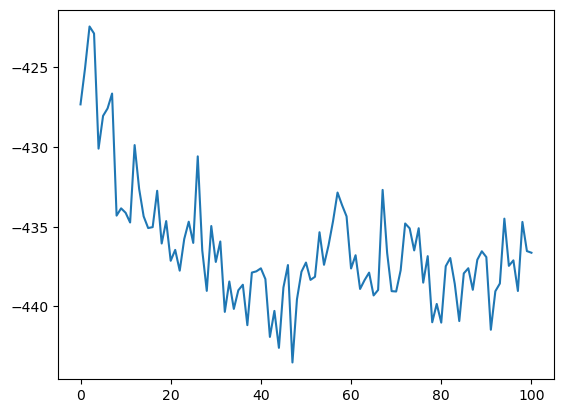

In [18]:
plt.plot(energies)